<a href="https://colab.research.google.com/github/anilbhatt1/CNN-EIP4-S5/blob/master/EIP4_S5_Assignment_5_Study_Version_Acc_0_71_ResNet50_PersonAttributes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace resized/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace resized/63.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50


In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head(2)

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg


In [0]:
type(df.gender)

pandas.core.series.Series

In [0]:
pd.get_dummies(df.gender, prefix="gender").head(3)

,gender_female,gender_male
0,0,1
1,1,0
2,0,1


In [0]:
type(df['image_path'])

pandas.core.series.Series

In [0]:
type(df[['image_path']])

pandas.core.frame.DataFrame

In [0]:
pd.concat([df[['image_path']],pd.get_dummies(df.gender,prefix='gender')],axis=1).head(3)

,image_path,gender_female,gender_male
0,resized/1.jpg,0,1
1,resized/2.jpg,1,0
2,resized/3.jpg,0,1


In [0]:
# one hot encoding of labels
# df[['image_path']] -> 2 brackets to ensure a dataframe is returned. If it is df['image path'], we will only get a series back
# pd.get_dummies will return a dataframe with 1 & 0 for column it is targetting. Check cell above
one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head(2).T

,0,1
image_path,resized/1.jpg,resized/2.jpg
gender_female,0,1
gender_male,1,0
imagequality_Average,1,1
imagequality_Bad,0,0
imagequality_Good,0,0
age_15-25,0,0
age_25-35,0,0
age_35-45,1,1
age_45-55,0,0


In [0]:
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_gender_cols_

['gender_female', 'gender_male']

In [0]:
type(_gender_cols_)

list

In [0]:
import keras
import numpy as np

# List comprehension [col for col in one_hot_df.columns if col.startswith("gender")] helps to select column names starting with 'gender' and
# put in a list
# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True,augmentation=None,incl_orig=False):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation
        self.incl_orig = incl_orig

# __len__ is a must function we need to give for keras sequence class, which will return number of batches in sequence 

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

# __getitem__ is a must function we need to give for keras sequence class, which will generate one batch of data
# index : Denotes index of batch

    def __getitem__(self, index):
        """fetch batched images and targets"""
 #       print('index',index)
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
 #       print('batch_slice',batch_slice)
        items = self.df.iloc[batch_slice]
 #       print('items:',items)
        # 'items' is a df generated from main df based on batch_size. 
        # items.iterrows() will take item['image_path'] and fetch it to cv2.imread(). '_' means ignore the index we get back from iterrows()
        # cv2.imread() will convert it to a numpy array which can be used by python
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])

        if self.augmentation is not None:
          self.augmentation.fit(image)
          image = self.augmentation.flow(image).next()

        # target is a dictionary. Against each key it keeps a tab of how many sub-categories each category has.
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

# on_epoch_end is a must function we need to give for keras sequence class, it will change index of batch after each epoch
# self.df.sample -> Return a random sample of items from the input df.
# frac = 1 denotes to return whole fraction of axis items
# reset_index(drop=True) drops the current index of the DataFrame and replaces it with an index of increasing integers

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
# giving random state as 42 to avoid data leak
# Else validation data will leak into train data & viceversa leading to high accuracies. Model will perform poor in unseen data in such cases
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15,random_state=42)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
train_df.head(2)

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
10416,resized/10418.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0
3495,resized/3496.jpg,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32, 
                                augmentation=ImageDataGenerator(rescale=1./255,
                                                                featurewise_center=True,
                                                                featurewise_std_normalization=True,
                                                                horizontal_flip=True,vertical_flip=False,rotation_range=90,width_shift_range=.2,
                                                                preprocessing_function=get_random_eraser(v_l=1, v_h=1)),incl_orig=True)
valid_gen = PersonDataGenerator(val_df, batch_size=32, shuffle=False,
                                augmentation=ImageDataGenerator(rescale=1./255,
                                                                featurewise_center=True,
                                                                featurewise_std_normalization=True))

index 0
batch_slice slice(0, 32, None)
items:            image_path  gender_female  ...  bodypose_Front-Frontish  bodypose_Side
0    resized/6551.jpg              1  ...                        0              0
1    resized/5394.jpg              0  ...                        1              0
2    resized/5292.jpg              0  ...                        0              1
3    resized/2328.jpg              0  ...                        0              0
4   resized/13561.jpg              0  ...                        0              1
5   resized/11191.jpg              1  ...                        0              0
6    resized/3746.jpg              1  ...                        0              1
7    resized/9017.jpg              1  ...                        1              0
8    resized/7095.jpg              0  ...                        1              0
9    resized/8529.jpg              0  ...                        1              0
10   resized/5914.jpg              1  ...           

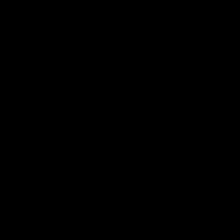

index 1
batch_slice slice(32, 64, None)
items:            image_path  gender_female  ...  bodypose_Front-Frontish  bodypose_Side
32   resized/1578.jpg              0  ...                        0              1
33   resized/6544.jpg              0  ...                        1              0
34   resized/7120.jpg              1  ...                        0              0
35   resized/3800.jpg              0  ...                        1              0
36   resized/4496.jpg              1  ...                        1              0
37   resized/6156.jpg              1  ...                        1              0
38   resized/9114.jpg              0  ...                        1              0
39   resized/1630.jpg              0  ...                        1              0
40  resized/10422.jpg              0  ...                        1              0
41   resized/7375.jpg              0  ...                        1              0
42   resized/7115.jpg              0  ...          

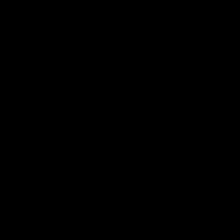

index 2
batch_slice slice(64, 96, None)
items:            image_path  gender_female  ...  bodypose_Front-Frontish  bodypose_Side
64   resized/2649.jpg              1  ...                        1              0
65   resized/9985.jpg              1  ...                        1              0
66   resized/4268.jpg              1  ...                        1              0
67   resized/6776.jpg              0  ...                        0              1
68   resized/5324.jpg              1  ...                        0              1
69  resized/10894.jpg              1  ...                        0              0
70   resized/6119.jpg              0  ...                        1              0
71   resized/3667.jpg              1  ...                        1              0
72   resized/9832.jpg              1  ...                        1              0
73   resized/5584.jpg              0  ...                        1              0
74   resized/5526.jpg              0  ...          

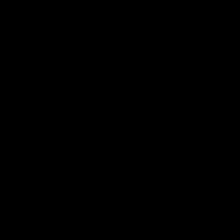

In [0]:
for i in range(3):
  cv2_imshow(train_gen[i][0][0])

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
# targets is a dictionary that we get from person data generator.
# k will get key value 'age_output' which will be split to get 'age' only
# v will get value of disctionary. We will take how many columns are there in v to understand classes within each class. eg: v.shape[1] will be 2
# for key 'gender_output' because there are 2 sub-categories 'male' & 'female
# these num_units will be later used to build the final model via build_head function
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

index 0
batch_slice slice(0, 32, None)
items:            image_path  gender_female  ...  bodypose_Front-Frontish  bodypose_Side
0    resized/6551.jpg              1  ...                        0              0
1    resized/5394.jpg              0  ...                        1              0
2    resized/5292.jpg              0  ...                        0              1
3    resized/2328.jpg              0  ...                        0              0
4   resized/13561.jpg              0  ...                        0              1
5   resized/11191.jpg              1  ...                        0              0
6    resized/3746.jpg              1  ...                        0              1
7    resized/9017.jpg              1  ...                        1              0
8    resized/7095.jpg              0  ...                        1              0
9    resized/8529.jpg              0  ...                        1              0
10   resized/5914.jpg              1  ...           

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
one_hot_df.head(3)

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,resized/1.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,resized/2.jpg,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
2,resized/3.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0


In [0]:
print(one_hot_df[one_hot_df['age_35-45'] == 1].shape[0])

3435


In [0]:
col_names = list(one_hot_df.columns.values)
len(col_names)
i = 0
for i in range(len(col_names)):
    print(col_names[i],one_hot_df[one_hot_df[col_names[i]] == 1].shape[0])

image_path 0
gender_female 5937
gender_male 7636
imagequality_Average 7509
imagequality_Bad 2240
imagequality_Good 3824
age_15-25 2494
age_25-35 5411
age_35-45 3435
age_45-55 1490
age_55+ 743
weight_normal-healthy 8628
weight_over-weight 891
weight_slightly-overweight 3196
weight_underweight 858
carryingbag_Daily/Office/Work Bag 4603
carryingbag_Grocery/Home/Plastic Bag 1321
carryingbag_None 7649
footwear_CantSee 5028
footwear_Fancy 2507
footwear_Normal 6038
emotion_Angry/Serious 1500
emotion_Happy 1609
emotion_Neutral 9660
emotion_Sad 804
bodypose_Back 2207
bodypose_Front-Frontish 8383
bodypose_Side 2983


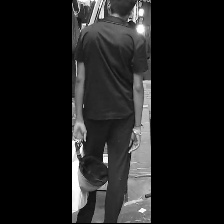

type:: <class 'numpy.ndarray'>


In [0]:
# To check if images are getting read correctly
from google.colab.patches import cv2_imshow
img = cv2.imread('resized/9213.jpg',0)
cv2_imshow(img)
print('type::',type(img))

In [0]:
backbone = ResNet50(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
neck = backbone.output  #backbone.output gives the last layer already build by VGG16 on the above statement (block5_maxpool)
neck = Flatten(name="flattener")(neck)  # Adds Flatten layer
neck = Dense(512, activation="relu")(neck) # Adds fully connected layer with Relu Activation

In [0]:
def build_tower(in_layer,dp1,dense1,dp2,dense2,act2=None):
    head = Dropout(dp1)(in_layer)
    head = Dense(dense1, activation="relu")(head)
    head = Dropout(dp2)(head)
    head = Dense(dense2, activation=act2)(head)
    return head

In [0]:
def build_tower02(in_layer,dp1,dense1,act2=None):
    head = Dropout(dp1)(in_layer)
    head = Dense(dense1, activation=act2)(head)
    return head

In [0]:
def build_head(name, activator,in_layer):
    return Dense(
        num_units[name], activation=activator, name=f"{name}_output"
    )(in_layer)

In [0]:
# heads
# Calls build_tower function with layers till previous point i.e. in_layer
# For each multi-label class, build_tower adds to in_layer following - dropout -> fully connected layer -> droput -> fully connected layer &  
# returns back to build_head.
# Build_head applies a dense layer with softmax/sigmoid activation on top of this to give final output for that particular class. eg: gender, age etc.
# 'M odel' API will use one 'neck' and connect one 'backbone'(VGG16) with 8 'heads'(below) which are built using build_head & build_tower

# gender = build_head("gender", "sigmoid", build_tower(neck))  #gender is binary classification
# image_quality = build_head("image_quality", "softmax",build_tower(neck)) # image is multi-class single label, can be either good, avg or bad
# age = build_head("age", "softmax",build_tower(neck))  # Age is regression to arbitrary value but here we are didving to groups like 15-25, 25-35, hence multi-class single label
# weight = build_head("weight", "softmax",build_tower(neck)) # weight is multi-class, single label as it can healthy, over or under
# bag = build_head("bag", "softmax",build_tower(neck))  # bag is multi-class, single label 
# footwear = build_head("footwear","softmax", build_tower(neck))  # multi-class, single label 
# emotion = build_head("emotion", "softmax", build_tower(neck))  # multi-class, single label 
# pose = build_head("pose", "softmax",build_tower(neck)) # multi-class, single label 

gender = build_head("gender", "softmax", build_tower(neck,dp1=0.2,dense1=128,dp2=0.3,dense2=128,act2='relu'))  #gender is binary classification
image_quality = build_head("image_quality", "sigmoid",build_tower(neck,dp1=0.2,dense1=256,dp2=0.1,dense2=128)) # image is multi-class single label, can be either good, avg or bad
age = build_head("age", "sigmoid",build_tower(neck,dp1=0.2,dense1=256,dp2=0.1,dense2=128))  # Age is regression to arbitrary value but here we are didving to groups like 15-25, 25-35, hence multi-class single label
weight = build_head("weight", "sigmoid",build_tower(neck,dp1=0.2,dense1=256,dp2=0.1,dense2=128)) # weight is multi-class, single label as it can healthy, over or under
bag = build_head("bag", "sigmoid",build_tower(neck,dp1=0.2,dense1=256,dp2=0.1,dense2=128))  # bag is multi-class, single label 
footwear = build_head("footwear","softmax", build_tower(neck,dp1=0.2,dense1=256,dp2=0.1,dense2=128))  # multi-class, single label 
emotion = build_head("emotion", "sigmoid", build_tower02(neck,dp1=0.2,dense1=256))  # multi-class, single label 
pose = build_head("pose", "sigmoid",build_tower(neck,dp1=0.2,dense1=256,dp2=0.1,dense2=128)) # multi-class, single label

In [0]:
model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

In [0]:
# freeze backbone
#for layer in backbone.layers:
#	print(layer)
#	layer.trainable = False

In [0]:
from keras.utils import plot_model
plot_model(model, show_shapes=True,to_file='model.png')

In [0]:
# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.004 * 1/(1 + 0.319 * epoch), 10)
opt = SGD(lr=0.003, momentum=0.9)
#opt = SGD(momentum=0.5)
model.compile(
    optimizer=opt,
#   loss = "binary_crossentropy",
    loss={"gender_output":"categorical_crossentropy", 
          "image_quality_output":"binary_crossentropy",
          "age_output":"binary_crossentropy",
          "weight_output":"binary_crossentropy",
          "bag_output":"binary_crossentropy",
          "emotion_output": "binary_crossentropy",
          "pose_output": "binary_crossentropy",
          "footwear_output": "binary_crossentropy"},
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)
model.summary()

In [0]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4, 
    epochs=2,
    verbose=1)
#    callbacks=[LearningRateScheduler(scheduler,verbose=1)])

Epoch 1/2
359/360 [============================>.] - ETA: 0s - loss: 37.9462 - gender_output_loss: 7.0222 - image_quality_output_loss: 5.3727 - age_output_loss: 3.2236 - weight_output_loss: 2.9359 - bag_output_loss: 7.0849 - footwear_output_loss: 5.9072 - pose_output_loss: 4.0987 - emotion_output_loss: 2.3010 - gender_output_acc: 0.5643 - image_quality_output_acc: 0.6667 - age_output_acc: 0.8000 - weight_output_acc: 0.8169 - bag_output_acc: 0.5580 - footwear_output_acc: 0.6315 - pose_output_acc: 0.7443 - emotion_output_acc: 0.8565

360/360 [==============================] - 212s 589ms/step - loss: 37.9336 - gender_output_loss: 7.0167 - image_quality_output_loss: 5.3727 - age_output_loss: 3.2236 - weight_output_loss: 2.9354 - bag_output_loss: 7.0847 - footwear_output_loss: 5.9047 - pose_output_loss: 4.0957 - emotion_output_loss: 2.3002 - gender_output_acc: 0.5647 - image_quality_output_acc: 0.6667 - age_output_acc: 0.8000 - weight_output_acc: 0.8169 - bag_output_acc: 0.5580 - footwear_o

In [0]:
model